In [19]:
import os
import torch
import torch.nn.functional
import torchvision
import torchvision.transforms as transforms
import numpy as np
import cv2
import matplotlib.pyplot as plt
from tqdm import tqdm

from utils_week13 import LeNet5

In [20]:
epoches = 4000
learning_rate = 1e-2
batch_size = 128
LAMBDA = 1e-3
device = device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

## 样本重建攻击
- 请大家按照ppt介绍的基于输出重建图像的方法，实现sim_loss与TV_loss，完成样本重建攻击
- 为保证实验效果，请大家不要更换optimizer、learning_rate以及epoches
  

- 实验技巧：（有助于借助错位简化TV_loss的计算）
    - 使用【:】操作符，控制数组的取值范围，以一维数组a = Tensor([1, 2, 3, 4])为例
        - a[:]，即保留a第一维从起始下标到终止下标的所有元素
            - a[:] = Tensor([1, 2, 3, 4])
        - a[start:]，即保留a第一维从下标start到终止下标的所有元素
            -a[1:] = Tensor([2, 3, 4])
        - a[:end]，即保留a第一维从起始下标到下标end的所有元素（不包含下标end）
            -a[:2] = Tensor([1, 2])
        - a[start:end]，即保留a第一维从下标start到到下标end的所有元素（不包含下标end）
            -a[1:3] = Tensor([2, 3])
- 实验可能使用到的一些函数：
    - torch.sum(input, dim)：计算input所有元素的和
    - torch.pow(input, d)：对input中每个元素计算其d次方的计算结果

In [21]:
model = LeNet5()
model.load_state_dict(torch.load('./model/lenet5.pt'))
model = model.to(device)

save_file = 'lenet5_reconstruction'
if not os.path.exists(save_file):
    os.makedirs(save_file)
    
def tensor_size(x):
    return x.shape[-1] * x.shape[-2]

C:\Users\w2213\AppData\Local\Temp\ipykernel_32076\1056856229.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('./model/lenet5.pt'))


In [22]:
correct = 0
for target_y in range(10):
    print(f"Reconstruction for class {target_y}")
    target_y = torch.tensor(target_y, device=device)
    target_output = torch.nn.functional.one_hot(target_y, num_classes=10).float().unsqueeze(0)

    # 初始化图像: [batch, channel, h, w]
    x = torch.zeros(1, 1, 28, 28, device=device)
    x.requires_grad = True
    
    # NOTE: 可基于重建效果为sim_loss选择不同criterion
    criterion = torch.nn.MSELoss(reduction='mean')
    # criterion = torch.nn.L1Loss()
    # criterion = torch.nn.CrossEntropyLoss()

    optimizer = torch.optim.Adam([x], lr=learning_rate)
    with torch.no_grad():
        prediction = model(x)
        original_diff = criterion(prediction, target_output)
        print(f"Begin Diff = {original_diff}")
    
    pbar = tqdm(range(1, epoches + 1))
    for epoch in pbar:
        # TODO：模型预测，计算基于输出相似度的sim_loss和TV_loss
        
        prediction = model(x)
        # sim_loss =  criterion(prediction, target_output)
        sim_loss = -torch.log_softmax(prediction, dim=1)[0, target_y]

        h = x.shape[2]
        w = x.shape[3]
        M = h * w
        h_diff = x[:, :, :, 1:] - x[:, :, :, :-1]
        v_diff = x[:, :, 1:, :] - x[:, :, :-1, :]
        TV_loss = (torch.sum(torch.pow(h_diff,2)) + torch.sum(torch.pow(v_diff,2))) / M

        loss = sim_loss + LAMBDA * TV_loss
        #TODO：反传梯度，更新模型
        optimizer.zero_grad()
        loss.backward()
        # torch.nn.utils.clip_grad_norm_([x], max_norm=1.0)
        optimizer.step()

        pbar.set_description(f"loss = {loss.detach():.6f}")

    # 验证重建后的图像标签
    with torch.no_grad():
        prediction = model(x)
        final_diff = criterion(prediction, target_output)
        print(f"Final Diff = {final_diff}")
    print(f"Target y = {target_y}, prediction = {torch.argmax(prediction, dim=1).item()}")
    if target_y == torch.argmax(prediction, dim=1).item(): correct += 1
    
    x_np = x.detach().cpu().numpy()
    
    img = x_np[0][0]
    img = cv2.resize(img, dsize=(200, 200), interpolation=cv2.INTER_NEAREST)
    img_mx, img_mn = np.max(img), np.min(img)
    img = (img - img_mn) / (img_mx - img_mn)
    img = np.uint8(img * 255)
    
    save_path = f"{save_file}/y={target_y}_avg.png"
    cv2.imwrite(save_path, img)
    print(f"Saved reconstructed image in {save_path}\n")

Reconstruction for class 0
Begin Diff = 0.20675304532051086


loss = 0.000089: 100%|██████████| 4000/4000 [00:15<00:00, 253.17it/s]


Final Diff = 25.515531539916992
Target y = 0, prediction = 0
Saved reconstructed image in lenet5_reconstruction/y=0_avg.png

Reconstruction for class 1
Begin Diff = 0.11365050077438354


loss = 0.000096: 100%|██████████| 4000/4000 [00:15<00:00, 257.13it/s]


Final Diff = 23.375215530395508
Target y = 1, prediction = 1
Saved reconstructed image in lenet5_reconstruction/y=1_avg.png

Reconstruction for class 2
Begin Diff = 0.16297473013401031


loss = 0.000070: 100%|██████████| 4000/4000 [00:15<00:00, 262.29it/s]


Final Diff = 19.90746307373047
Target y = 2, prediction = 2
Saved reconstructed image in lenet5_reconstruction/y=2_avg.png

Reconstruction for class 3
Begin Diff = 0.09583093971014023


loss = 0.000071: 100%|██████████| 4000/4000 [00:16<00:00, 245.56it/s]


Final Diff = 33.68626022338867
Target y = 3, prediction = 3
Saved reconstructed image in lenet5_reconstruction/y=3_avg.png

Reconstruction for class 4
Begin Diff = 0.21246337890625


loss = 0.000061: 100%|██████████| 4000/4000 [00:28<00:00, 138.42it/s]


Final Diff = 18.589094161987305
Target y = 4, prediction = 4
Saved reconstructed image in lenet5_reconstruction/y=4_avg.png

Reconstruction for class 5
Begin Diff = 0.09798093140125275


loss = 0.000075: 100%|██████████| 4000/4000 [00:15<00:00, 251.74it/s]


Final Diff = 23.3707275390625
Target y = 5, prediction = 5
Saved reconstructed image in lenet5_reconstruction/y=5_avg.png

Reconstruction for class 6
Begin Diff = 0.19565263390541077


loss = 0.000060: 100%|██████████| 4000/4000 [00:15<00:00, 254.57it/s]


Final Diff = 26.4639949798584
Target y = 6, prediction = 6
Saved reconstructed image in lenet5_reconstruction/y=6_avg.png

Reconstruction for class 7
Begin Diff = 0.12646323442459106


loss = 0.000054: 100%|██████████| 4000/4000 [00:15<00:00, 253.16it/s]


Final Diff = 30.816049575805664
Target y = 7, prediction = 7
Saved reconstructed image in lenet5_reconstruction/y=7_avg.png

Reconstruction for class 8
Begin Diff = 0.14573296904563904


loss = 0.000066: 100%|██████████| 4000/4000 [00:16<00:00, 248.67it/s]


Final Diff = 16.203065872192383
Target y = 8, prediction = 8
Saved reconstructed image in lenet5_reconstruction/y=8_avg.png

Reconstruction for class 9
Begin Diff = 0.1318030059337616


loss = 0.000087: 100%|██████████| 4000/4000 [00:15<00:00, 255.38it/s]

Final Diff = 33.22639083862305
Target y = 9, prediction = 9
Saved reconstructed image in lenet5_reconstruction/y=9_avg.png



- 统计预测成功率

In [23]:
succ_ratio = float(correct/10)*100
print(f"Acc = {succ_ratio:.2f}%")

Acc = 100.00%


- 可视化图像

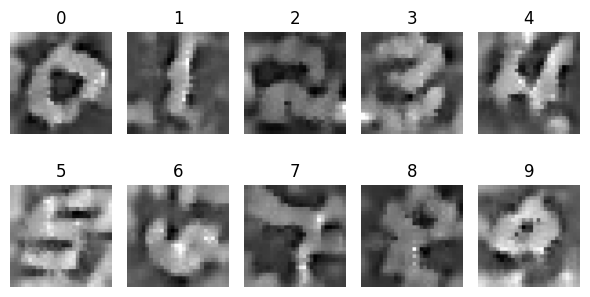

In [24]:
# 如果jupyter内核崩溃加下面两行
# import os
# os.environ['KMP_DUPLICATE_LIB_OK']='True'
fig = plt.figure(figsize=(6, 4))

files = os.listdir(save_file)
for file in files:
    y = file.split('=')[-1].split('_')[0]
    img = cv2.imread(f"{save_file}/{file}")
    
    ax = fig.add_subplot(2, 5, int(y)+1)
    
    ax.set_title(y)
    ax.set_axis_off()
    plt.imshow(img)
    plt.tight_layout()